https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py


https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

## 1. Análisis descriptivo del problema, análisis exploratorio y preprocesado de datos.

Este problema está basado en un ejemplo del libro de Williams y Rasmussen (apartado 5.4.3), que también ha sido utilizado por algunos de los desarrolladores de Scikit-Learn. Trata sobre mediciones de CO$2$ que se han captado en el Observatorio del volcán Mauna Loa, en Hawái. El dataset está disponible en la página web de la Oficina Nacional de Administración Oceánica y Atmosférica de los Estados Unidos.

https://gml.noaa.gov/ccgg/trends/data.html

Los datos están distribuidos por año, mes y día, dando el CO$2$ captado en la medida 'partes por millón' (ppm). También hay $2$ características más, *weight* y *flag*, que no nos interesan para este ejercicio.


In [155]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve, KFold

Cargo los datos iniciales:

In [156]:
datos = fetch_openml(data_id=41187, as_frame=True)
datos.frame.head()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,year,month,day,weight,flag,station,co2
0,1958.0,3.0,29.0,4.0,0.0,MLO,316.1
1,1958.0,4.0,5.0,6.0,0.0,MLO,317.3
2,1958.0,4.0,12.0,4.0,0.0,MLO,317.6
3,1958.0,4.0,19.0,6.0,0.0,MLO,317.5
4,1958.0,4.0,26.0,2.0,0.0,MLO,316.4


In [157]:
df = datos.frame

# Crear DataFrame de polars
df_polars = pl.DataFrame(df)

In [158]:
# Comprobar la cantidad de instancias y características
instancias, caracteristicas = df_polars.shape


print("Cantidad de instancias:", instancias)
print("\nCantidad de características:", caracteristicas - 1) #quito el CO2

Cantidad de instancias: 2225

Cantidad de características: 6


Comprobamos que no haya missing values:

In [159]:
# Analizar valores perdidos
df_pandas = df_polars.to_pandas()
missing_values = df_pandas.isnull().sum()
print("Valores perdidos por columna:\n", missing_values)

Valores perdidos por columna:
 year       0
month      0
day        0
weight     0
flag       0
station    0
co2        0
dtype: int64


Vemos que tenemos mediciones consistentes a lo largo del tiempo:

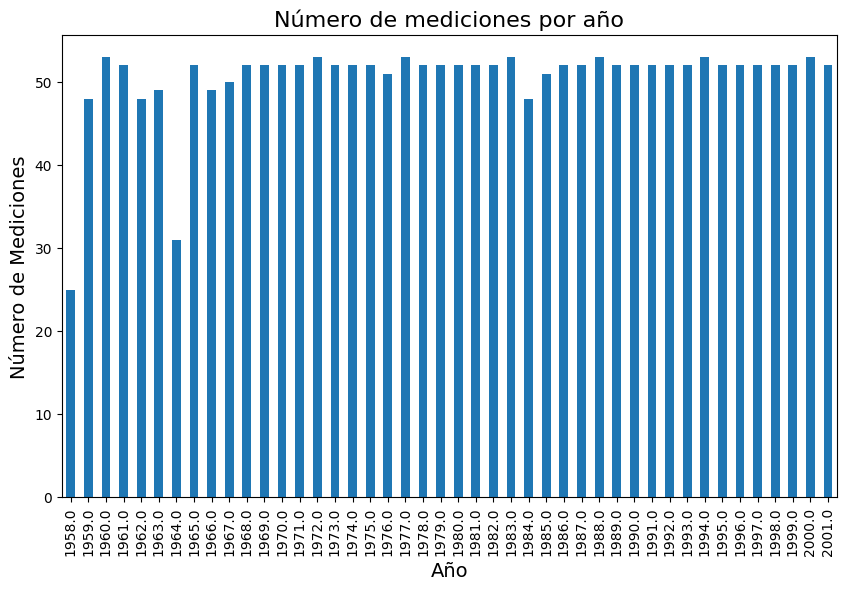

In [160]:
# Contar mediciones por año
mediciones_por_ano = df_pandas['year'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(10, 6))
mediciones_por_ano.plot(kind='bar')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de Mediciones', fontsize=14)
plt.title('Número de mediciones por año', fontsize=16)
plt.show()

Juntamos las columnas de la fecha y despreciamos weight y flag:

In [161]:
import polars as pl

datos = pl.DataFrame(datos.frame[["year", "month", "day", "co2"]]).select(
    pl.date("year", "month", "day"), "co2"
)
datos.head()

date,co2
date,f64
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


Veo el rango de las fechas:

In [162]:
datos["date"].min(), datos["date"].max()

(datetime.date(1958, 3, 29), datetime.date(2001, 12, 29))

Se hará el siguiente preprocesamiento de datos: Se toma la media mensual y se eliminarán los meses en los que no se haya recogido datos sobre los niveles de CO2. Así se suavizarán los datos.

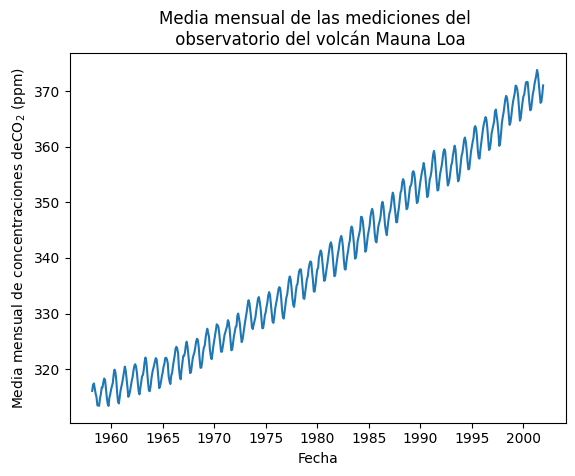

In [163]:
datos = (
    datos.sort(by="date")
    .group_by_dynamic("date", every="1mo")
    .agg(pl.col("co2").mean())
    .drop_nulls()
)
plt.plot(datos["date"], datos["co2"])
plt.xlabel("Fecha")
plt.ylabel("Media mensual de concentraciones deCO$_2$ (ppm)")
_ = plt.title(
    "Media mensual de las mediciones del \n observatorio del volcán Mauna Loa"
)

Dividir en train y test:

In [164]:


# Seleccionar las características y la etiqueta
X = datos[['date']]
y = datos['co2']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de prueba:", X_test.shape[0])

Tamaño del conjunto de entrenamiento: 416
Tamaño del conjunto de prueba: 105


De forma auxiliar, para entender mejor los datos creo una variable que sean los días que han pasado desde el inicio:

In [165]:
X_train_aux = X_train

# Convertir polars DataFrame a pandas DataFrame
X_train_aux = X_train_aux.to_pandas()

# Convertir la columna de fecha a días desde el inicio
X_train_aux['dias_desde_inicio'] = (X_train_aux['date'] - X_train_aux['date'].min()).dt.days

X_train_aux = X_train_aux.drop(['date'], axis=1)

X_train_aux.head()

,dias_desde_inicio
0,15859
1,5509
2,13271
3,10257
4,12663


Ahora hacemos el análisis estadístico. (A partir de aquí utilizaremos solo los datos de train, si no sería data snooping)

In [166]:
# Análisis estadístico
statistical_summary = y_train.describe()
print("Resumen estadístico:\n", statistical_summary)

Resumen estadístico:
 shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 416.0      │
│ null_count ┆ 0.0        │
│ mean       ┆ 340.170581 │
│ std        ┆ 16.811154  │
│ min        ┆ 313.4      │
│ 25%        ┆ 324.95     │
│ 50%        ┆ 339.22     │
│ 75%        ┆ 354.675    │
│ max        ┆ 373.8      │
└────────────┴────────────┘


In [99]:
import numpy as np

#((NOTA: ESTA CELDA SI SE EJECUTA EN ORDEN VA A DAR ERROR. SE EJECUTÓ ABAJO, TRAS PASAR LOS DATOS DE TIPO FECHA A NÚMERO))

# Calcular estadísticas básicas de X_train
mean_x = np.mean(X_train)
median_x = np.median(X_train)
std_x = np.std(X_train)
min_x = np.min(X_train)
max_x = np.max(X_train)
q1_x = np.percentile(X_train, 25)
q3_x = np.percentile(X_train, 75)
size_x = X_train.shape[0]  # Tamaño de X_test_sorted

# Imprimir las estadísticas
print("Resumen estadístico de X_train:")
print(f"   Tamaño: {size_x}")
print(f"   Media: {mean_x:.2f}")
print(f"   Mediana: {median_x:.2f}")
print(f"   Desviación estándar: {std_x:.2f}")
print(f"   Mínimo: {min_x:.2f}")
print(f"   Máximo: {max_x:.2f}")
print(f"   Primer cuartil (Q1): {q1_x:.2f}")
print(f"   Tercer cuartil (Q3): {q3_x:.2f}")

Resumen estadístico de X_train:
   Tamaño: 416
   Media: 1980.62
   Mediana: 1980.88
   Desviación estándar: 12.34
   Mínimo: 1958.33
   Máximo: 2001.83
   Primer cuartil (Q1): 1970.23
   Tercer cuartil (Q3): 1991.27


Las mediciones se toman distribuidas en 15981 días (las fechas van desde 1958 hasta 2001).

Las mediciones de CO2 van de 313 a 373.

Histogramas de los datos:

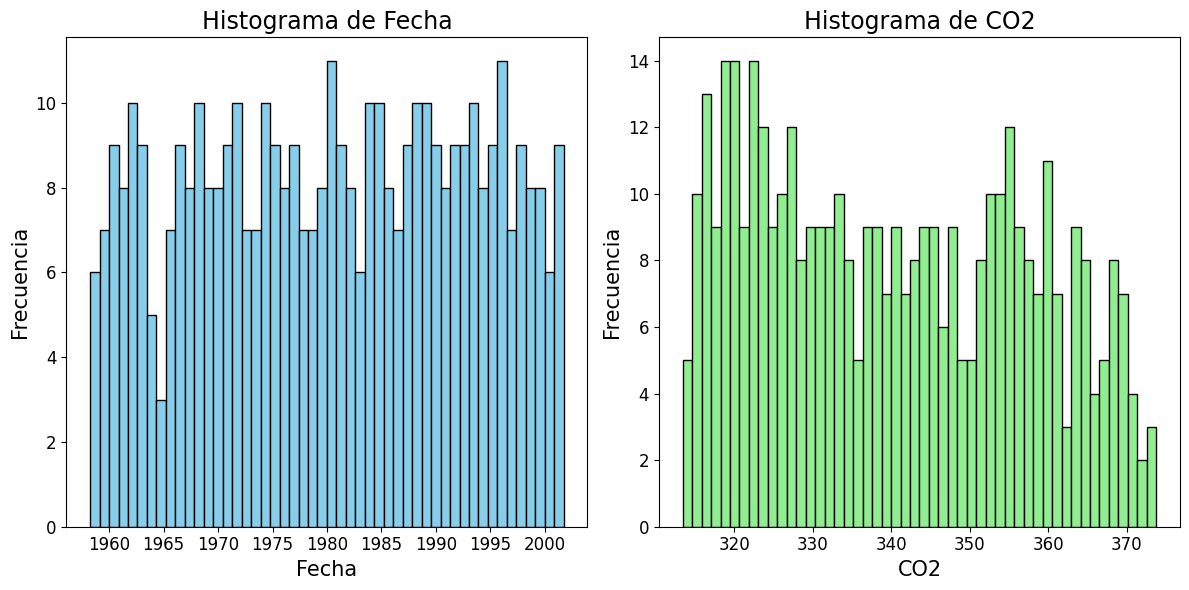

In [167]:
# Graficar histogramas
plt.figure(figsize=(12, 6))

# Histograma de días desde el inicio
plt.subplot(1, 2, 1)
plt.hist(X_train['date'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Fecha', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histograma de Fecha', fontsize=17)

# Histograma de CO2
plt.subplot(1, 2, 2)
plt.hist(y_train, bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('CO2', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)
plt.title('Histograma de CO2', fontsize=17)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

En general las fechas de las mediciones están repartidas durante el tiempo. Vemos que las medidas de CO2 no están tan distribuidas, los valores más altos están en menor cantidad.

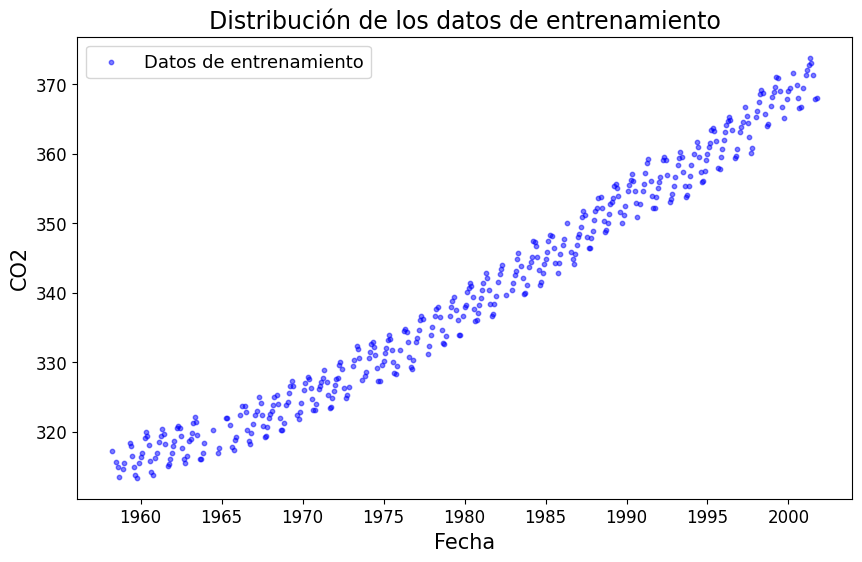

In [168]:
import matplotlib.pyplot as plt

# Gráfico de dispersión de los datos de entrenamiento
plt.figure(figsize=(10, 6))
plt.scatter(X_train['date'], y_train, color='blue', alpha=0.5, s=10, label='Datos de entrenamiento')
plt.xlabel('Fecha', fontsize=15)
plt.ylabel('CO2', fontsize=15)
plt.title('Distribución de los datos de entrenamiento', fontsize=17)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=13)
plt.show()


Se transforma el dato de la fecha a un número:

In [169]:
X_train = X_train.select(
    pl.col("date").dt.year() + pl.col("date").dt.month() / 12
).to_numpy()

X_test = X_test.select(
    pl.col("date").dt.year() + pl.col("date").dt.month() / 12
).to_numpy()

In [170]:
y_train = y_train.to_numpy()

In [171]:
y_test = y_test.to_numpy()

En este problema no tendremos que reducir dimensionalidad: ahora solo hay 1 característica!

Pero sí que se normalizarán los datos:

In [172]:
from sklearn.preprocessing import MinMaxScaler

# Primero normalizo los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(creo que mejor voy a usar standardscaler)

In [173]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Escalar los datos con StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Definición del protocolo de validación experimental

Se guarda el 20% de los datos para test.

Las métricas utilizadas para observar el rendimiento de los modelos tanto en test como en la validación del cross-validation serán el **error cuadrático medio** (MSE) y el **coeficiente de determinación** ($R^2$):

MSE: El Error Cuadrático Medio es una medida comúnmente utilizada para evaluar el rendimiento de un modelo de regresión. Se calcula tomando la media de los cuadrados de las diferencias entre los valores predichos por el modelo y los valores reales del conjunto de datos de prueba. Cuanto menor sea el valor de MSE, mejor será el rendimiento del modelo, lo que indica que las predicciones del modelo están más cerca de los valores reales. Su fórmula será:

$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

donde n será el número de observaciones, , $y_i$ el valor real de la i-ésima observación e $\hat{y}_i$ el valor que predice el modelo para la i-ésima observación.

**$R^2$**: Es una medida que indica cuánta variabilidad en la variable de destino es explicada por las variables independientes del modelo. Un valor de 1 indica un ajuste perfecto, mientras que un valor de 0 indica que el modelo no explica ninguna variabilidad. Su fórmula es:

$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$

donde $\bar{y}$ es el valor medio de las observaciones reales, $y_i$ el valor real de la i-ésima observación e $\hat{y}_i$ el valor que predice el modelo para la i-ésima observación.

## 3. Modelos de Aprendizaje Automático

Los tres modelos que voy a utilizar serán:
- Procesos Gaussianos

- Gradient Boosting

- Support Vector Machines

Para este problema utilizaré un kernel más complejo que los RBF ya empleados en los problemas de clasificación. Usaré una combinación de kernels que se detallará más adelante. Además, cabe destacar que no tiene sentido usar kernels anisotrópicos, ya que solo tenemos una característica.

En el apartado 5.2.2 se trabajó también con SVM, sin embargo, como en esta ocasión se trabaja con un problema de regresión, habrá ciertas diferencias con el SVC utilizado anteriormente. Se usará la clase **Support Vector Regression (SVR)** de Scikit-Learn, que a diferencia del SVC no busca encontrar un hiperplano para separar las clases, sino que busca ajustar el mayor número posible de instancias en la 'calle' limitando al mismo tiempo las instancias que quedan fuera del margen. La anchura del margen se determina a través de un hiperparámetro $ϵ$.

El **Gradient Boosting** es un potente algoritmo de aprendizaje supervisado que se puede utilizar tanto en problemas de clasificación como de regresión. Utiliza la técnica del **boosting**, que consiste en juntar varios predictores débiles para hacerlos fuertes. En concreto, junta múltiples árboles de decisión que se entrenan de forma secuencial, de forma que los árboles intentan corregir los errores que han cometido los árboles anteriores en el entrenamiento: cada árbol se ajusta a los residuos (diferencia entre los valores reales y los predichos) del modelo anterior en lugar de los datos originales. Este proceso se realiza iterativamente, minimizando una función de pérdida mediante el **descenso de gradiente**. Para evitar el overfitting este modelo utiliza regularización.





## 4. Selección de hiperparámetros y ejecución.

### GPR

Primero determinaremos el kernel a usar. Para ello, se pueden hacer algunas suposiciones sobre los datos de entrenamiento: se observa una tendencia creciente a largo plazo, una variación estacional pronunciada y algunas irregularidades más pequeñas. Combinaremos varios kernels para adecuarnos a nuestros datos:


Primero, la tendencia creciente a largo plazo podría ajustarse utilizando un kernel RBF con un parámetro length_scale grande, que hará que esta componente sea suave. La escala específica y la amplitud son hiperparámetros libres.

In [174]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

La variación estacional se explica mediante el kernel periódico exponencial seno cuadrado con una periodicidad fija de 1 año. La escala de longitud de este componente periódico, que controla su suavidad, es un parámetro libre. Para permitir *decay* lejos de la periodicidad exacta, se utiliza el producto con un núcleo RBF. La escala de longitud de este componente RBF controla el tiempo de *decay* y es otro parámetro libre. Este tipo de núcleo también se conoce como kernel localmente periódico.

In [175]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

Las pequeñas irregularidades observadas en los datos se explican mediante un componente de kernel cuadrático racional, cuyo length_scale y parámetro $α$, que cuantifica la difusión de los length_scale, deben determinarse durante el entrenamiento. Un kernel cuadrático racional es equivalente a un núcleo RBF con varias escalas de longitud y se adaptará mejor a las diferentes irregularidades.

In [176]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

Finalmente, el ruido en el conjunto de datos se puede tener en cuenta con un kernel que consiste en una contribución del núcleo RBF, el cual explica los componentes de ruido correlacionados como fenómenos meteorológicos locales, y una contribución de White Kernel para el ruido blanco. Las amplitudes relativas y la escala de longitud del RBF son parámetros libres adicionales.

In [177]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

Se forma el kernel final combinando los kernels:

In [178]:
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

In [179]:
X_train_scaled=X_train
X_test_scaled=X_test

Para Procesos Gaussianos no he hecho selección de hiperparámetros explícitamente, ya que la búsqueda de los mejores hiperparámetros para el 'kernel' la realiza el propio método 'fit'.

In [180]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Inicializar los modelos de procesos gaussianos con kernel elegido
gpr_iso = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)

# Crear el objeto KFold con 5 particiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el MSE usando validación cruzada en el conjunto de entrenamiento
mse_PG_iso_training = -cross_val_score(gpr_iso, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_PG_iso_training = mse_PG_iso_training.mean()
print("MSE en entrenamiento (validación cruzada):", mse_PG_iso_training)

# Calcular el R² usando validación cruzada en el conjunto de entrenamiento
r2_PG_iso_training = cross_val_score(gpr_iso, X_train_scaled, y_train, cv=kf, scoring='r2')
r2_PG_iso_training = r2_PG_iso_training.mean()
print("R2 en entrenamiento (validación cruzada):", r2_PG_iso_training)

# Entrenar los modelos en el conjunto de entrenamiento completo
gpr_iso.fit(X_train_scaled, y_train - y_train.mean())

# Acceder a los hiperparámetros del kernel
kernel_params = gpr_iso.kernel_
print("Hiperparámetros del kernel después del entrenamiento:", kernel_params)

# Realizar predicciones en el conjunto de prueba
y_pred_iso,std_y_pred = gpr_iso.predict(X_test_scaled, return_std=True)
y_pred_iso += y_train.mean()

# Calcular el MSE del modelo
mse_PG_iso_test = mean_squared_error(y_test, y_pred_iso)
print("MSE del modelo de procesos gaussianos (test):", mse_PG_iso_test)

# Calcular el R2 del modelo
r2_PG_iso_test = r2_score(y_test, y_pred_iso)
print("R2 del modelo de procesos gaussianos (test):", r2_PG_iso_test)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklear

MSE en entrenamiento (validación cruzada): 0.06894482274180122


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklear

R2 en entrenamiento (validación cruzada): 0.9997507562375322
Hiperparámetros del kernel después del entrenamiento: 43.6**2 * RBF(length_scale=50.6) + 2.51**2 * RBF(length_scale=104) * ExpSineSquared(length_scale=1.4, periodicity=1) + 0.525**2 * RationalQuadratic(alpha=11.2, length_scale=0.981) + 0.193**2 * RBF(length_scale=0.136) + WhiteKernel(noise_level=0.0386)
MSE del modelo de procesos gaussianos (test): 0.055761195398592873
R2 del modelo de procesos gaussianos (test): 0.9998276047649113


Train sizes: [ 33  66  99 132 166 199 232 265 298 332]
Train scores (mean): [0.00404453 0.00452257 0.00142937 0.00200644 0.00468077 0.00897048
 0.0125379  0.01798307 0.0148672  0.02278739]
Test scores (mean): [0.28648752 0.16860319 0.12457469 0.10898936 0.09545716 0.09034593
 0.08707334 0.07834671 0.07321902 0.06899763]


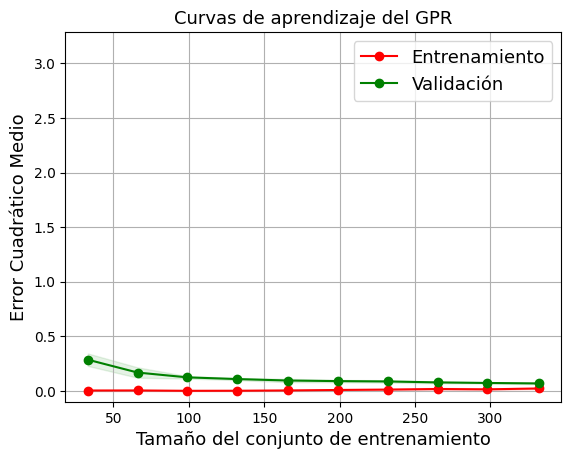

In [186]:
# Generar las curvas de aprendizaje para GPR
train_sizes, train_scores, test_scores = learning_curve(
    gpr_iso, X_train_scaled, y_train, cv=kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'
)

# Convertir los resultados negativos a positivos para interpretarlos como MSE
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Imprimir los valores para verificar
print("Train sizes:", train_sizes)
print("Train scores (mean):", train_scores_mean)
print("Test scores (mean):", test_scores_mean)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del GPR", fontsize=13)
plt.xlabel("Tamaño del conjunto de entrenamiento", fontsize=13)
plt.ylabel("Error Cuadrático Medio", fontsize=13)
plt.ylim(np.min(train_scores_mean) - 0.1, np.max(test_scores_mean) + 3)  # Ajusta los límites del eje y
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best", fontsize=13)
plt.show()

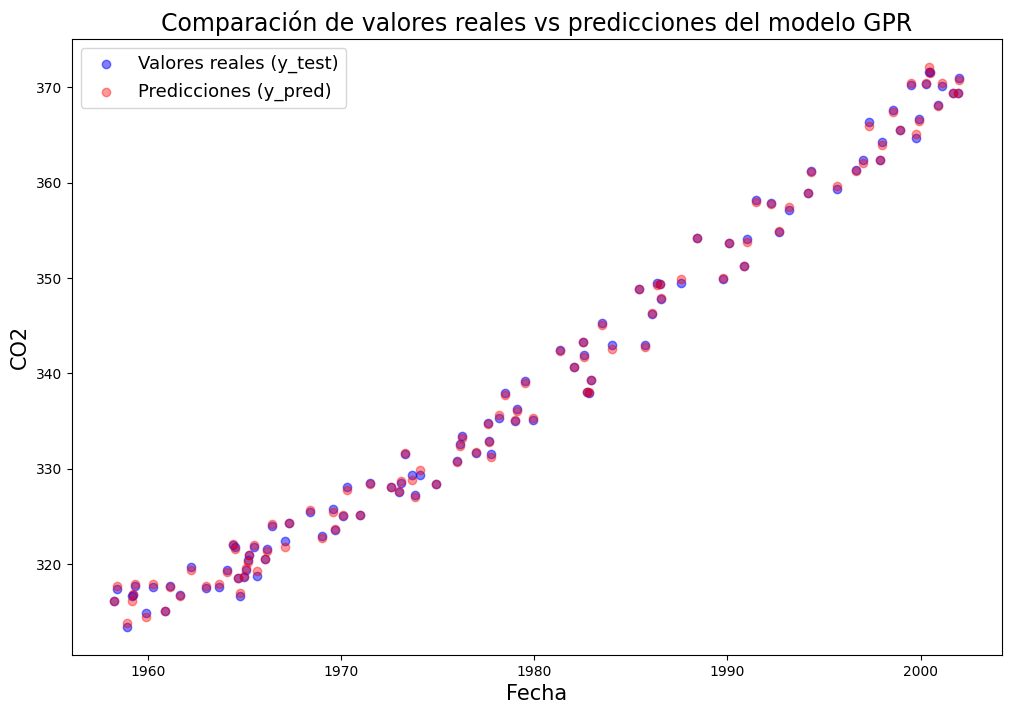

In [187]:
import matplotlib.pyplot as plt

# Gráfico de dispersión de los valores reales vs las predicciones
plt.figure(figsize=(12, 8))

# Dibujar los puntos reales
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Valores reales (y_test)')

# Dibujar los puntos predichos
plt.scatter(X_test, y_pred_iso, color='red', alpha=0.4, label='Predicciones (y_pred)')

# Etiquetas y título
plt.xlabel('Fecha', fontsize=15)
plt.ylabel('CO2', fontsize=15)
plt.title('Comparación de valores reales vs predicciones del modelo GPR',fontsize=17)
plt.legend(fontsize=13)
plt.show()


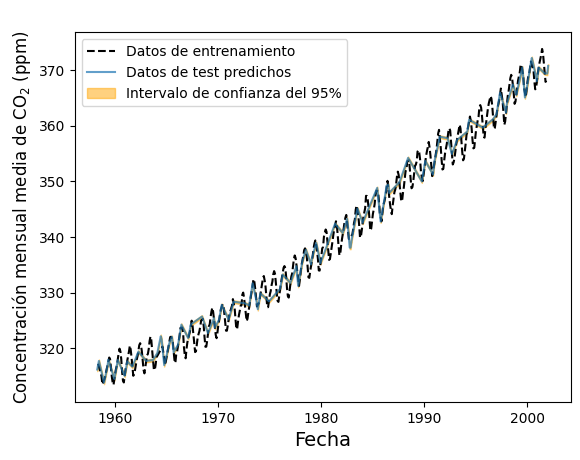

In [189]:
sorted_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test.ravel()[sorted_indices]
y_pred_iso_sorted,std_y_pred_sorted = gpr_iso.predict(X_test_sorted[:, np.newaxis], return_std=True)
y_pred_iso_sorted += y_train.mean()

sorted_indices_train = np.argsort(X_train.ravel())
X_train_sorted = X_train.ravel()[sorted_indices_train]
y_train_sorted = y_train.ravel()[sorted_indices_train]

plt.plot(X_train_sorted, y_train_sorted, color="black", linestyle="dashed", label="Datos de entrenamiento")
plt.plot(X_test_sorted, y_pred_iso_sorted, color="tab:blue", alpha=0.7, label="Datos de test predichos")
plt.fill_between(
    X_test_sorted.ravel(),
    y_pred_iso_sorted - std_y_pred_sorted,
    y_pred_iso_sorted + std_y_pred_sorted,
    label=r"Intervalo de confianza del 95%",
    color="orange",
    alpha=0.5,
)
plt.legend()
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Concentración mensual media de CO$_2$ (ppm)", fontsize=12)
_ = plt.title(
    " "
)

In [95]:
# Obtener la predicción media y la desviación estándar de la predicción
mean_prediction, std_prediction = gpr_iso.predict(X_test_scaled, return_std=True)
mean_prediction += y_train.mean()

# Imprimir los primeros 10 valores de la predicción media y la desviación estándar
print("Predicción media:", mean_prediction[:10])
print("Desviación estándar de la predicción:", std_prediction[:10])


Predicción media: [368.00413697 324.22774324 313.79588829 336.07461665 321.35525564
 347.91670922 327.67048573 342.77174403 339.26675821 365.53794485]
Desviación estándar de la predicción: [0.24328917 0.23963664 0.25874807 0.25309474 0.25556432 0.25320875
 0.25353841 0.23847665 0.261022   0.24122204]


In [96]:
import numpy as np

# Calcular estadísticas básicas de X_test_sorted
mean_x = np.mean(X_test_sorted)
median_x = np.median(X_test_sorted)
std_x = np.std(X_test_sorted)
min_x = np.min(X_test_sorted)
max_x = np.max(X_test_sorted)
q1_x = np.percentile(X_test_sorted, 25)
q3_x = np.percentile(X_test_sorted, 75)
size_x = X_test_sorted.shape[0]  # Tamaño de X_test_sorted

# Imprimir las estadísticas
print("Resumen estadístico de X_test_sorted:")
print(f"   Tamaño: {size_x}")
print(f"   Media: {mean_x:.2f}")
print(f"   Mediana: {median_x:.2f}")
print(f"   Desviación estándar: {std_x:.2f}")
print(f"   Mínimo: {min_x:.2f}")
print(f"   Máximo: {max_x:.2f}")
print(f"   Primer cuartil (Q1): {q1_x:.2f}")
print(f"   Tercer cuartil (Q3): {q3_x:.2f}")


Resumen estadístico de X_test_sorted:
   Tamaño: 105
   Media: 1979.04
   Mediana: 1977.75
   Desviación estándar: 13.45
   Mínimo: 1958.25
   Máximo: 2002.00
   Primer cuartil (Q1): 1966.17
   Tercer cuartil (Q3): 1990.83


Para extrapolar hasta fechas más allá de 2001 utilizo el siguiente conjunto de test:

In [100]:
import datetime
import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test_extrapolacion = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred_extrapolacion, std_y_pred_extrapolacion = gpr_iso.predict(X_test_extrapolacion, return_std=True)
mean_y_pred_extrapolacion += y_train.mean()

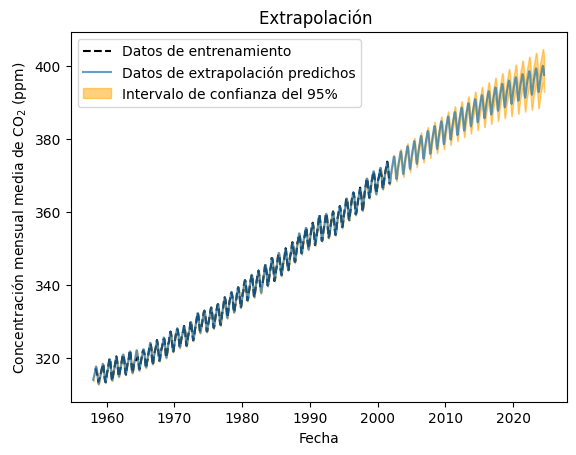

In [101]:
plt.plot(X_train_sorted, y_train_sorted, color="black", linestyle="dashed", label="Datos de entrenamiento")
plt.plot(X_test_extrapolacion, mean_y_pred_extrapolacion, color="tab:blue", alpha=0.7, label="Datos de extrapolación predichos")
plt.fill_between(
    X_test_extrapolacion.ravel(),
    mean_y_pred_extrapolacion - std_y_pred_extrapolacion,
    mean_y_pred_extrapolacion + std_y_pred_extrapolacion,
    label=r"Intervalo de confianza del 95%",
    color="orange",
    alpha=0.5,
)
plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Concentración mensual media de CO$_2$ (ppm)")
_ = plt.title(
    "Extrapolación "
)

### SVR

In [102]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'C': [0.1, 1, 10, 100],                # Parámetro de regularización
    'gamma': [1, 0.1, 0.01, 0.001],        # Coeficiente del kernel RBF
    'kernel': ['rbf', 'linear', 'sigmoid'],            # Tipo de kernel
    'epsilon': [0.01, 0.1, 0.5, 1]         # Margen de la 'calle'
}

# Inicializar el modelo SVR
svr = SVR()

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda en la cuadrícula con los datos de entrenamiento
grid_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros y el mejor score
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score de validación cruzada (MSE):", -grid_search.best_score_)


Mejores hiperparámetros: {'C': 100, 'epsilon': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Mejor score de validación cruzada (MSE): 4.804242958587851


In [120]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np


# Inicializo el modelo con los mejores hiperparámetros obtenidos:
svr = SVR(C=100, gamma=0.001, kernel='rbf', epsilon=1)

# Crear el objeto KFold con 5 particiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el MSE usando validación cruzada en el conjunto de entrenamiento
mse_svr_training = -cross_val_score(svr, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_svr_training = mse_svr_training.mean()
print("MSE en entrenamiento (validación cruzada):", mse_svr_training)

# Calcular el R² usando validación cruzada en el conjunto de entrenamiento
r2_svr_training = cross_val_score(svr, X_train_scaled, y_train, cv=kf, scoring='r2')
r2_svr_training = r2_svr_training.mean()
print("R2 en entrenamiento (validación cruzada):", r2_svr_training)

# Entrenar los modelos en el conjunto de entrenamiento completo
svr.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_svr = svr.predict(X_test_scaled)

# Calcular el MSE del modelo
mse_svr_test = mean_squared_error(y_test, y_pred_svr)
print("MSE del modelo de SVM (test):", mse_svr_test)

# Calcular el R2 del modelo
r2_svr_test = r2_score(y_test, y_pred_svr)
print("R2 del modelo de SVM (test):", r2_svr_test)

MSE en entrenamiento (validación cruzada): 4.7683219731259685
R2 en entrenamiento (validación cruzada): 0.9827469957742883
MSE del modelo de SVM (test): 3.4021690934640048
R2 del modelo de SVM (test): 0.9894816146517859


Train sizes: [ 33  66  99 132 166 199 232 265 298 332]
Train scores (mean): [5.83611935 5.07143307 5.01483368 5.13723635 5.07867033 4.81650046
 4.83515922 4.88882945 4.77405708 4.66019225]
Test scores (mean): [5.95967036 5.21138967 5.02956077 4.90452994 4.92125178 4.89611783
 4.87633637 4.93350053 4.81447113 4.76809699]


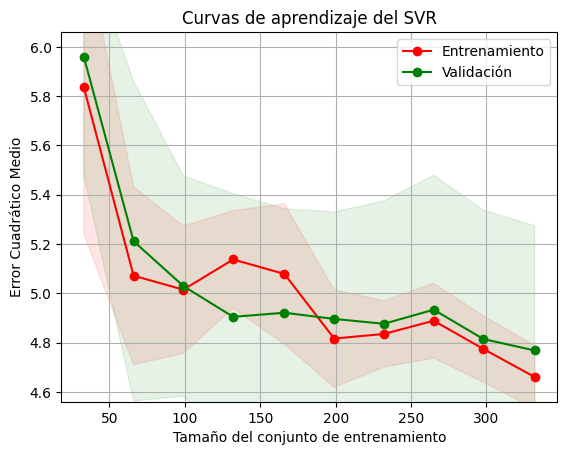

In [121]:
# Generar las curvas de aprendizaje para SVR
train_sizes, train_scores, test_scores = learning_curve(
    svr, X_train_scaled, y_train, cv=kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'
)

# Convertir los resultados negativos a positivos para interpretarlos como MSE
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Imprimir los valores para verificar
print("Train sizes:", train_sizes)
print("Train scores (mean):", train_scores_mean)
print("Test scores (mean):", test_scores_mean)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del SVR")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error Cuadrático Medio")
plt.ylim(np.min(train_scores_mean) - 0.1, np.max(test_scores_mean) + 0.1)  # Ajusta los límites del eje y
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best")
plt.show()

### Gradient Boosting

In [105]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árboles en el bosque
    'learning_rate': [0.01, 0.1, 0.2],     # Tasa de aprendizaje
    'max_depth': [3, 4, 5],                # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],       # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],         # Número mínimo de muestras requeridas en un nodo hoja
    'subsample': [0.8, 1.0]                # Fracción de muestras para entrenar cada árbol base
}

# Inicializar el modelo Gradient Boosting
gb = GradientBoostingRegressor()

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error')

# Ejecutar la búsqueda en la cuadrícula con los datos de entrenamiento
grid_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros y el mejor score
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score de validación cruzada (MSE):", -grid_search.best_score_)


Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}
Mejor score de validación cruzada (MSE): 1.424818548188386


In [122]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np


# Inicializar el modelo Gradient Boosting con los mejores hiperparámetros encontrados
gb = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=300,
    subsample=0.8
)

# Crear el objeto KFold con 5 particiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el MSE usando validación cruzada en el conjunto de entrenamiento
mse_gb_training = -cross_val_score(gb, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_gb_training = mse_gb_training.mean()
print("MSE en entrenamiento (validación cruzada):", mse_gb_training)

# Calcular el R² usando validación cruzada en el conjunto de entrenamiento
r2_gb_training = cross_val_score(gb, X_train_scaled, y_train, cv=kf, scoring='r2')
r2_gb_training = r2_gb_training.mean()
print("R2 en entrenamiento (validación cruzada):", r2_gb_training)

# Entrenar los modelos en el conjunto de entrenamiento completo
gb.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_gb = gb.predict(X_test_scaled)

# Calcular el MSE del modelo
mse_gb_test = mean_squared_error(y_test, y_pred_gb)
print("MSE del modelo de SVM (test):", mse_gb_test)

# Calcular el R2 del modelo
r2_gb_test = r2_score(y_test, y_pred_gb)
print("R2 del modelo de SVM (test):", r2_gb_test)

MSE en entrenamiento (validación cruzada): 1.4245751974830498
R2 en entrenamiento (validación cruzada): 0.994939450321878
MSE del modelo de SVM (test): 1.0791710419881944
R2 del modelo de SVM (test): 0.9966635588754031


Train sizes: [ 33  66  99 132 166 199 232 265 298 332]
Train scores (mean): [1.32599076e-05 5.02046572e-04 2.75313469e-03 6.85126386e-03
 1.29258530e-02 2.00652357e-02 2.62088453e-02 3.22683474e-02
 3.58714282e-02 4.10465779e-02]
Test scores (mean): [11.45640591  9.50290829  6.90648017  5.41454835  4.35697606  3.08897585
  2.50325878  2.03941585  1.68205853  1.40879231]


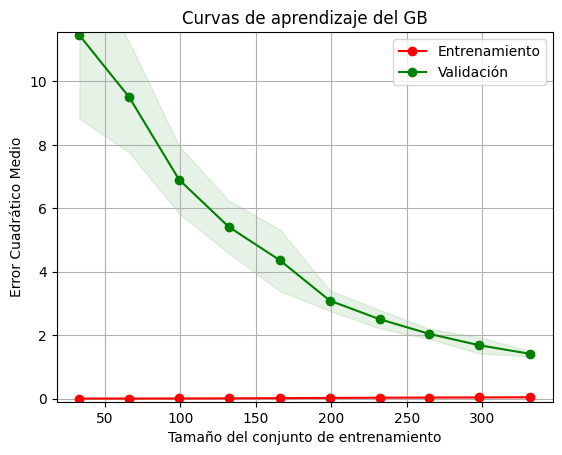

In [123]:
# Generar las curvas de aprendizaje para SVR
train_sizes, train_scores, test_scores = learning_curve(
    gb, X_train_scaled, y_train, cv=kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'
)

# Convertir los resultados negativos a positivos para interpretarlos como MSE
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Imprimir los valores para verificar
print("Train sizes:", train_sizes)
print("Train scores (mean):", train_scores_mean)
print("Test scores (mean):", test_scores_mean)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del GB")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error Cuadrático Medio")
plt.ylim(np.min(train_scores_mean) - 0.1, np.max(test_scores_mean) + 0.1)  # Ajusta los límites del eje y
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best")
plt.show()

## 5. Resultados

In [125]:
from tabulate import tabulate

# Crear la lista de resultados
results = [
    ["Procesos Gaussianos", mse_PG_iso_training, r2_PG_iso_training],
    ["SVM", mse_svr_training, r2_svr_training],
    ["Gradient Boosting", mse_gb_training, r2_gb_training]
]

# Encabezados de la tabla
headers = ["Modelo", "MSE (cross-validation)", "R2 (cross-validation)"]

# Imprimir la tabla
print(tabulate(results, headers=headers, tablefmt="pretty"))


+---------------------+------------------------+-----------------------+
|       Modelo        | MSE (cross-validation) | R2 (cross-validation) |
+---------------------+------------------------+-----------------------+
| Procesos Gaussianos |  0.44709632904078767   |  0.9983751304413016   |
|         SVM         |   4.7683219731259685   |  0.9827469957742883   |
|  Gradient Boosting  |   1.4245751974830498   |   0.994939450321878   |
+---------------------+------------------------+-----------------------+


In [126]:
from tabulate import tabulate

# Crear la lista de resultados
results = [
    ["Procesos Gaussianos", mse_PG_iso_test, r2_PG_iso_test],
    ["SVM", mse_svr_test, r2_svr_test],
    ["Gradient Boosting", mse_gb_test, r2_gb_test]
]

# Encabezados de la tabla
headers = ["Modelo", "MSE (test)", "R2 (test)"]

# Imprimir la tabla
print(tabulate(results, headers=headers, tablefmt="pretty"))


+---------------------+--------------------+--------------------+
|       Modelo        |     MSE (test)     |     R2 (test)      |
+---------------------+--------------------+--------------------+
| Procesos Gaussianos | 0.5697280745008415 | 0.9982385885984302 |
|         SVM         | 3.4021690934640048 | 0.9894816146517859 |
|  Gradient Boosting  | 1.0791710419881944 | 0.9966635588754031 |
+---------------------+--------------------+--------------------+
